# Object detection from Scratch

Object Localization, which is finding where a single object exists in an image.

Object detection is finding what and where(multiple) objects are in an image.

classification - what is that image.
detection - go in depth detect what are the objects.

image - CNN - classify if its a cat or dog

image - CNN - detection bounding box ( two ways 1. (x1, y1) determines the upper left corner point, (x2, y2) determines bottom right corner points, 2. Two points define corner points and two points define height and width )

Natural extension of localization is **sliding windows** of the bounding box, this approach uses first problem is a lot of computations which can be overcomed by using Regional based neural network (RCNN, fast rcnn, faster rcnn) creating potential bounding boxes still (slow XD), therefore finally YOLO was introduced, each cell is goingto predict first if there is a bounding box in that cell and second what is the class probability for that particular cell.

and second problem is making many different size of the bounding boxes.





# Intersection over union
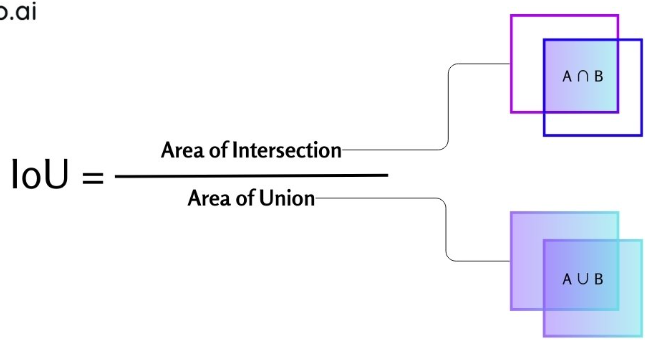

IoU > 0.5 means it is decent
Iou > 0.7 means pretty good
Iou > 0.7 means almost perfect

So how do we find for Iou for these numbers
predicted box1 = x1, y1, x2, y2
actual box2 = x1, y1, x2, y2
is by finding minimum or maximum based on the intersection and then dividing by the union.

In [1]:
import torch

def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    # (N, 4) where N is the number of bounding boxes
    # boxes_labels shape is also (N, 4)

    if box_format == "midpoint":
        # Convert (x_center, y_center, width, height) to (x1, y1, x2, y2)
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Compute the intersection coordinates.
    #Calculate the coordinates of the intersection rectangle by taking the maximum of the top-left corner and the minimum of the bottom-right corner between the two boxes.
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Clamp values at 0 to handle cases where boxes do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Calculate the areas of the bounding boxes and the intersection
    #box area caluclation is width * height, where width (x2-x1) and height (y2-y1)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Compute the union area
    union = box1_area + box2_area - intersection + 1e-6

    return intersection / union


# Non max suppresion
alot of bounding boxes, we first check which bounding box gives highest probability and then calculate IoU of that box with other box in the region and if it is greater than a threshold then we remove that other box.

therefore NMS should be for that particular class

In [2]:

def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Performs Non-Maximum Suppression (NMS) to remove overlapping bounding boxes.

    Parameters:
    - bboxes (list or tensor): List or tensor of bounding boxes with each box described as
      [class_pred, confidence_score, x1, y1, x2, y2] in corners format
      or [class_pred, confidence_score, x_center, y_center, width, height] in midpoint format.
    - iou_threshold (float): IoU threshold for deciding whether to suppress a box.
    - threshold (float): Confidence threshold to filter out low-confidence predictions.
    - box_format (str): Format of the bounding boxes ("corners" or "midpoint").

    Returns:
    - List of bounding boxes after applying NMS.
    """
    assert isinstance(bboxes, list), "bboxes should be a list"

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    nms_bboxes = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box for box in bboxes
            if box[0] != chosen_box[0] or
            intersection_over_union(torch.tensor(chosen_box[2:]), torch.tensor(box[2:]), box_format=box_format) < iou_threshold
        ]

        nms_bboxes.append(chosen_box)

    return nms_bboxes

# Mean Average Precision
Precision is the ratio of correctly predicted positive instances (true positives) to the total predicted positive instances (true positives + false positives).
Recall is the ratio of correctly predicted positive instances (true positives) to the total actual positive instances (true positives + false negatives).

AP is recall precision curve and area under curve.

mAP is the mean of the AP values across all classes. If there are multiple classes in the dataset (e.g., detecting different types of objects like cars, pedestrians, and bicycles), AP is calculated separately for each class, and then the mean of these AP values is computed.


mAP@IoU=0.5: This is a common setting where the IoU threshold is set to 0.5, meaning a predicted bounding box is considered a true positive if it has an IoU of at least 0.5 with a ground truth box.
mAP@[0.5:0.95]: Some evaluations, like those used in COCO (Common Objects in Context) benchmarks, use mAP calculated across multiple IoU thresholds (e.g., from 0.5 to 0.95 in steps of 0.05) to provide a more comprehensive assessment of model performance.

In [3]:
def calculate_mAP(pred_boxes, true_boxes, iou_threshold=0.5, num_classes=20, box_format="corners"):
    """
    Calculates the mean average precision (mAP) across all classes.

    Parameters:
    - pred_boxes (list): list containing all bboxes with each bbox specified as
                         [image_idx, class_prediction, confidence_score, x1, y1, x2, y2]
    - true_boxes (list): similar to pred_boxes, but containing the ground truth bboxes
    - iou_threshold (float): threshold where predicted bbox is correct
    - num_classes (int): number of classes
    - box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
    - mAP (float): Mean Average Precision across all classes
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Find the amount of bboxes for each image
        amount_bboxes = defaultdict(int)
        for bbox in ground_truths:
            amount_bboxes[bbox[0]] += 1

        # Store each bounding box of class c in a dictionary
        true_positives = torch.zeros(len(detections))
        false_positives = torch.zeros(len(detections))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            img_detections = [bbox for bbox in ground_truths if bbox[0] == detection[0]]
            best_iou = 0
            best_gt_idx = -1

            for idx, gt in enumerate(img_detections):
                iou = intersection_over_union(torch.tensor(detection[2:]), torch.tensor(gt[2:]), box_format=box_format)

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]] > 0:
                    true_positives[detection_idx] = 1
                    amount_bboxes[detection[0]] -= 1
                else:
                    false_positives[detection_idx] = 1
            else:
                false_positives[detection_idx] = 1

        # Calculate precision and recall
        tp_cumsum = torch.cumsum(true_positives, dim=0)
        fp_cumsum = torch.cumsum(false_positives, dim=0)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + epsilon)
        recalls = tp_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precision = torch.trapz(precisions, recalls)
        average_precisions.append(average_precision)

    return sum(average_precisions) / len(average_precisions)